# 18.337 Problem set 2: Image Seam speedup
For this problem set, I chose to focus on improvements to the serial algorithm to minimize duplicate computations and unnecessary allocations. 

## Minimizing allocations
There were two primary steps involved in minimizing the number of memory allocations and deallocations during computation: creating a stable workspace and preventing the creation of temporary arrays. 

### Stable workspace
The reference implementation re-computes the brightness, energy, cumulative energy (which I will call \em{cost-to-go} here), directions, and other quantities every time a new seam was removed. This results in many temporary variables being created and subsequently destroyed: julia's @time macro reports over 70Gb of allocations when precomputing all image sizes for the Stata image. To address this, I created a single type, `CarvableImage`, to hold all the necessary matrices. Calling `carve!()` on a `CarvableImage` updates the energies, cost-to-go, directions, and seam for an image, mutating its workspace variables. Importantly, `carve!()` does not resize any of the workspace variables. Instead, a mutable `width` field tracks the shrinking width of the image, and allows the user to extract a view into the resized image later. 

### Preventing temporary arrays
A few sections of the reference implementation turned out to produce massive temporary allocations. Specifically, code such as: 

```
s, dirs[x-1,y] = findmin(e[x+[-1, 0, 1], y+1])
```

turned out to be extremely costly, due to the need to construct a temporary array `[-1, 0, 1]`, and another to hold `x + [-1, 0, 1]`. Pre-allocating the array `[-1, 0, 1]` and replacing the `x + [-1, 0, 1]` with a short loop resulted in a 50X reduction in allocations and a 5X reduction in runtime. 

## Preventing duplicate computations
To reduce the number of duplicate computations, I relied on the observation that removal of a seam only modifies the energies from near the seam to the right edge of the image. Thus, we can save time by only re-computing the energies and cost-to-go from the seam to the edge of the image. 

# Structure of this code
My code lives in the Julia module `ImageSeam` contained in this folder. I have also created another Julia module called `ImageSeamReference` which contains the original implementation provided in class. The function you'll want is called `precompute_all_sizes(img)` in both modules. 

## Installation
To load these modules, you'll need to make sure that the folder containing this notebook is in your LOAD_PATH variable. You can do that with:

```
push!(LOAD_PATH, "/path/to/this/folder")
```

In [39]:
using Images
using Interact

In [40]:
# This is a utility function (you do not need to understand it) 
# which overrides Ijulia's image widget so that manipulate displays with the proper width
immutable ImgFrame
    img::Image
end
Base.writemime(io::IO, m::MIME"text/html", frame::ImgFrame) = 
write(io, """<img src="data:image/png;base64,$(stringmime(MIME("image/png"), frame.img))"/>""")

writemime (generic function with 38 methods)

In [46]:
import ImageSeamReference
reload("ImageSeamReference")

In [47]:
import ImageSeam
reload("ImageSeam")

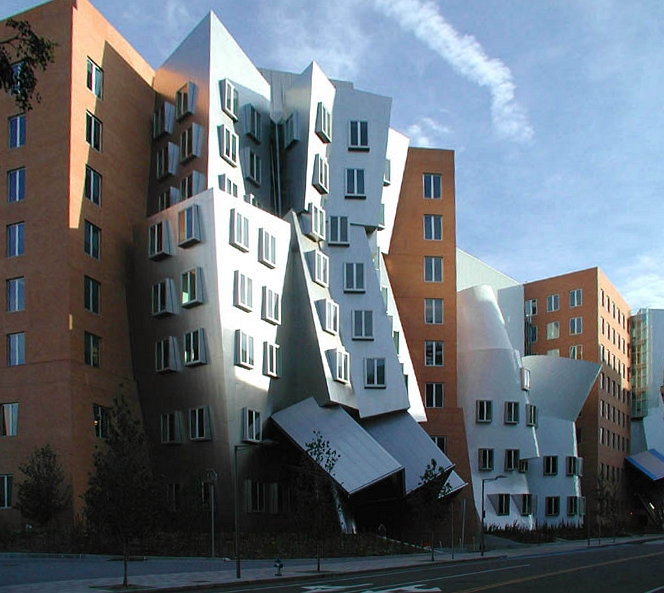

In [52]:
# # Wikipedia demo
# if ~isfile("320px-Broadway_tower_edit.jpg")
#     run(`wget https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Broadway_tower_edit.jpg/320px-Broadway_tower_edit.jpg`)
# end
# img = imread("320px-Broadway_tower_edit.jpg")

if ~isfile("Wfm_stata_center.jpg")
  run(`wget http://upload.wikimedia.org/wikipedia/commons/2/25/Wfm_stata_center.jpg`)
end
img = imread("Wfm_stata_center.jpg")

In [53]:
# jit-compile both methods
A = ImageSeam.precompute_all_sizes(img)
# @assert ImageSeam.verify(A)
ImageSeamReference.precompute_all_sizes(img)
nothing # so we don't try to print out A

In [56]:
# Now let's compare timing results
A = []
println("Reference implementation:")
@time A = ImageSeamReference.precompute_all_sizes(img)
A = []
println("Improved implementation:")
@time A = ImageSeam.precompute_all_sizes(img)
nothing

Reference implementation:
 63.293575 seconds (1.35 G allocations: 74.737 GB, 23.55% gc time)
Improved implementation:
  4.438192 seconds (17.99 k allocations: 510.723 MB, 4.62% gc time)


Interact.Slider{Int64}([Reactive.Input{Int64}] 664,"",664,2:664)

ImgFrame(RGB4 Images.Image with:
  data: 664x593 Array{ColorTypes.RGB4{FixedPointNumbers.UfixedBase{UInt8,8}},2}
  properties:
    imagedescription: <suppressed>
    spatialorder:  x y
    pixelspacing:  1 1)
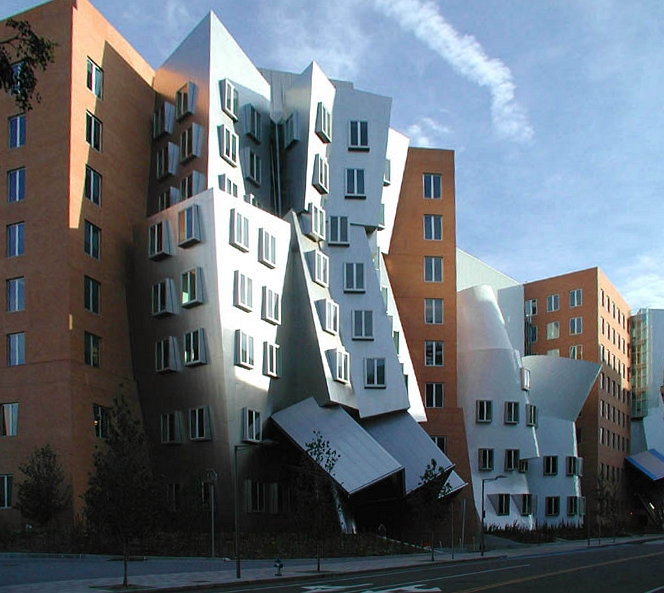

In [55]:
@manipulate for image_width=slider(2:size(img,1), value=size(img,1))
    ImgFrame(A[1+size(img,1)-image_width])
end

# Results
My implementation results in a speedup of roughly 15X over the reference implmentation, purely by removing unnecessary allocations and computations. I demonstrate computing all sizes for the Stata image in 4.4 seconds on a MacBook Pro with a 2.5 GHz Intel Core i7, compared to 63.3 seconds for the reference implementation. 